## This notebook focus on importing the SVTK output

In [23]:
%%configure -f
{"driverMemory": "6000M"}

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


In [24]:
import hail as hl
hl.init(sc)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 3.1.2-amzn-0
SparkUI available at
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.80-4ccfae1ff293
LOGGING: writing to

In [25]:
anno_sv_uri = "SG10K-SV-Release-1.4-HighConfidenceSV-withMetadata.svtk.gencode40.vcf.gz"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
svtk_mt = hl.import_vcf(anno_sv_uri, reference_genome="GRCh38", force_bgz=True)
print(svtk_mt.count())
svtk_mt.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(73035, 5487)
----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        SVTYPE: str, 
        SVSIZE: int32, 
        END: int32, 
        AC_CHINESE: int32, 
        AN_CHINESE: int32, 
        AF_CHINESE: float64, 
        AC_MALAY: int32, 
        AN_MALAY: int32, 
        AF_MALAY: float64, 
        AC_INDIAN: int32, 
        AN_INDIAN: int32, 
        AF_INDIAN: float64, 
        LOF: array<str>, 
        DUP_LOF: array<str>, 
        COPY_GAIN: array<str>, 
        DUP_PARTIAL: array<str>, 
        MSV_EXON_OVR: array<str>, 
        INTRONIC: array<str>, 
        INV_SPAN: array<str>, 
        UTR: array<str>, 
        NEAREST_TSS: array<str>, 
        promoter: bool, 
        INTERGENIC: bool
    }
--------------

In [27]:
# Get allele frequency class
mt2 = svtk_mt
mt2 = mt2.annotate_rows( 
    hom_ref_cnt  = hl.agg.count_where(mt2.GT.is_hom_ref()),
    hom_var_cnt  = hl.agg.count_where(mt2.GT.is_hom_var()),
    het_cnt  = hl.agg.count_where(mt2.GT.is_het())
)

mt2 = mt2.annotate_rows( 
    num_of_variants = mt2.hom_var_cnt + mt2.het_cnt
)
mt2.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        SVTYPE: str, 
        SVSIZE: int32, 
        END: int32, 
        AC_CHINESE: int32, 
        AN_CHINESE: int32, 
        AF_CHINESE: float64, 
        AC_MALAY: int32, 
        AN_MALAY: int32, 
        AF_MALAY: float64, 
        AC_INDIAN: int32, 
        AN_INDIAN: int32, 
        AF_INDIAN: float64, 
        LOF: array<str>, 
        DUP_LOF: array<str>, 
        COPY_GAIN: array<str>, 
        DUP_PARTIAL: array<str>, 
        MSV_EXON_OVR: array<str>, 
        INTRONIC: array<str>, 
        INV_SPAN: array<str>, 
        UTR: array<str>, 
        NEAREST_TSS: array<str>, 
        promoter: bool, 
        INTERGENIC: bool
    }
    'hom_ref_cnt': int64
   

In [28]:
# Run variant_qc to get AF
mt2 = hl.variant_qc(mt2)

mt2 = mt2.annotate_rows(
    AF_class = hl.case()
            .when((mt2.variant_qc.AF[1] < 0.001),  "Ultra-rare")
            .when((mt2.variant_qc.AF[1] >= 0.001) & (mt2.variant_qc.AF[1] < 0.01), "Rare")
            .when((mt2.variant_qc.AF[1] >= 0.01), "Common")
            .default("NA") 
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
## Check to see if there are any variants without AF_class
test = mt2.filter_rows(~hl.is_defined(mt2.AF_class))
test.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0, 5487)
2024-04-22 08:12:27 Hail: INFO: Coerced sorted dataset

In [30]:
conditions = [
    {'key': 'is_LOF', 'expr': ( hl.is_defined(mt2.info.LOF) ) },
    {'key': 'is_DUP_LOF', 'expr': ( hl.is_defined(mt2.info.DUP_LOF)  ) },
    {'key': 'is_COPY_GAIN', 'expr': ( hl.is_defined(mt2.info.COPY_GAIN) ) }, 
]

mt2 = mt2.annotate_rows(
    svtk_annot2 = hl.set(hl.filter(
        lambda x: hl.is_defined(x),
        [hl.or_missing(
            d['expr'],
            d['key']
        ) for d in conditions]
    ))
)

mt2.describe()
mt2.rows().show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        SVTYPE: str, 
        SVSIZE: int32, 
        END: int32, 
        AC_CHINESE: int32, 
        AN_CHINESE: int32, 
        AF_CHINESE: float64, 
        AC_MALAY: int32, 
        AN_MALAY: int32, 
        AF_MALAY: float64, 
        AC_INDIAN: int32, 
        AN_INDIAN: int32, 
        AF_INDIAN: float64, 
        LOF: array<str>, 
        DUP_LOF: array<str>, 
        COPY_GAIN: array<str>, 
        DUP_PARTIAL: array<str>, 
        MSV_EXON_OVR: array<str>, 
        INTRONIC: array<str>, 
        INV_SPAN: array<str>, 
        UTR: array<str>, 
        NEAREST_TSS: array<str>, 
        promoter: bool, 
        INTERGENIC: bool
    }
    'hom_ref_cnt': int64
   

In [31]:
svtk_annot_af_class_ht = mt2.select_rows(mt2.AF_class, mt2.svtk_annot2).rows()
svtk_annot_af_class_gp_ht = (svtk_annot_af_class_ht.group_by("AF_class").aggregate(total=hl.agg.counter(svtk_annot_af_class_ht.svtk_annot2))).cache()
svtk_annot_af_class_gp_ht.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+
| AF_class     |
+--------------+
| str          |
+--------------+
| "Common"     |
| "Rare"       |
| "Ultra-rare" |
+--------------+

+------------------------------------------------------------------------------+
| total                                                                        |
+------------------------------------------------------------------------------+
| dict<set<str>, int64>                                                        |
+------------------------------------------------------------------------------+
| {{}:19165,{"is_DUP_LOF"}:8,{"is_COPY_GAIN","is_DUP_LOF"}:1,{"is_LOF"}:92,... |
| {{}:11653,{"is_DUP_LOF"}:21,{"is_COPY_GAIN","is_DUP_LOF"}:4,{"is_LOF"}:78... |
| {{}:40064,{"is_DUP_LOF"}:199,{"is_COPY_GAIN","is_DUP_LOF"}:31,{"is_LOF"}:... |
+------------------------------------------------------------------------------+

2024-04-22 08:13:15 Hail: INFO: Coerced sorted dataset
2024-04-22 08:13:39 Hail: INFO: Coerced sorted dataset
2024-0

In [32]:
svtk_annot_af_class_gp_ht.show(width=1000)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+----------------------------------------------------------------------------------------------------+
| AF_class     | total                                                                                              |
+--------------+----------------------------------------------------------------------------------------------------+
| str          | dict<set<str>, int64>                                                                              |
+--------------+----------------------------------------------------------------------------------------------------+
| "Common"     | {{}:19165,{"is_DUP_LOF"}:8,{"is_COPY_GAIN","is_DUP_LOF"}:1,{"is_LOF"}:92,{"is_COPY_GAIN"}:10}      |
| "Rare"       | {{}:11653,{"is_DUP_LOF"}:21,{"is_COPY_GAIN","is_DUP_LOF"}:4,{"is_LOF"}:78,{"is_COPY_GAIN"}:102}    |
| "Ultra-rare" | {{}:40064,{"is_DUP_LOF"}:199,{"is_COPY_GAIN","is_DUP_LOF"}:31,{"is_LOF"}:838,{"is_COPY_GAIN"}:769} |
+--------------+----------------------------------------

<Figure size 1000x2000 with 0 Axes>

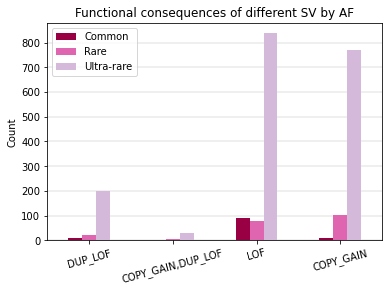

In [33]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plot
from matplotlib.pyplot import figure

palette=[  '#980043' , '#df65b0' , '#d4b9da']

figure(figsize=(10, 20), dpi=100)
# Initialize data to Dicts of series.
d = {'Common': pd.Series([8,1,92,10],
                        index = ['DUP_LOF', 'COPY_GAIN,DUP_LOF', 'LOF', 'COPY_GAIN']),
      'Rare' : pd.Series([21, 4, 78, 102],
                        index =['DUP_LOF', 'COPY_GAIN,DUP_LOF', 'LOF', 'COPY_GAIN']),
     
    'Ultra-rare' : pd.Series([199, 31, 838, 769],
                       index =['DUP_LOF', 'COPY_GAIN,DUP_LOF', 'LOF', 'COPY_GAIN'])
    }

df = pd.DataFrame(d)

ax = df.plot.bar(rot=15, title="Functional consequences of different SV by AF", ylabel="Count", color = palette)
ax.grid(axis="y" , linewidth=0.4)
ax.set_axisbelow(True)

plot.show()

In [12]:
## Save the matrix table with svtk annotation
svtk_mt_uri = "SG10K-SV-Release-1.4-HighConfidenceSV-WithMetadata-svtkAnnotation.mt"
mt2.write(svtk_mt_uri, overwrite=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2024-04-22 07:02:03 Hail: INFO: Coerced sorted dataset
2024-04-22 07:03:37 Hail: INFO: wrote matrix table with 73035 rows and 5487 columns in 3 partitions to SG10K-SV-Release-1.4-HighConfidenceSV-WithMetadata-svtkAnnotation.mt

### Save plots to s3
#### install boto3

In [13]:
%%sh
pip install boto3

In [14]:
import boto3
import io
import matplotlib.pyplot as plt
import seaborn as sns

def save_fig_to_s3(fig, bucket, key):
    img_data = io.BytesIO()
    fig.savefig(img_data, format='svg', dpi=300)
    img_data.seek(0)

    s3 = boto3.client('s3')
    response = s3.put_object(Bucket=bucket, Key=key, Body=img_data, ContentType='image/svg')
    print(response)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
import pandas as pd
import matplotlib.pyplot as plot
from matplotlib.pyplot import figure

palette=[  '#980043' , '#df65b0' , '#d4b9da']

figure(figsize=(10, 20), dpi=100)
# Initialize data to Dicts of series.
d = {'Common': pd.Series([8,1,93,10],
                        index = ['DUP_LOF', 'COPY_GAIN,DUP_LOF', 'LOF', 'COPY_GAIN']),
      'Rare' : pd.Series([21, 4, 78, 102],
                        index =['DUP_LOF', 'COPY_GAIN,DUP_LOF', 'LOF', 'COPY_GAIN']),
     
    'Ultra-rare' : pd.Series([199, 31, 838, 769],
                       index =['DUP_LOF', 'COPY_GAIN,DUP_LOF', 'LOF', 'COPY_GAIN'])
    }

df = pd.DataFrame(d)

ax = df.plot.bar(rot=15, title="Functional consequences of different SV by AF", ylabel="Count", color = palette)
ax.grid(axis="y" , linewidth=0.4)
ax.set_axisbelow(True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
save_fig_to_s3(plot, "Figures", "fig3c_FunctionalPredictions.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Get the size of LOF vs Copy Gain events

In [17]:
svtk_annot_class_ht = mt2.select_rows(mt2.svtk_annot2, mt2.info.SVSIZE, mt2.info.SVTYPE).rows()
svtk_annot_class_ht.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------------------------+-------------+--------+--------+
| locus         | alleles                | svtk_annot2 | SVSIZE | SVTYPE |
+---------------+------------------------+-------------+--------+--------+
| locus<GRCh38> | array<str>             | set<str>    |  int32 | str    |
+---------------+------------------------+-------------+--------+--------+
| chr1:54720    | ["C","<DUP>"]          | {}          |     54 | "DUP"  |
| chr1:66534    | ["T","<DUP>"]          | {}          |     58 | "DUP"  |
| chr1:83963    | ["A","<DUP>"]          | {}          |     75 | "DUP"  |
| chr1:99061    | ["C","<DUP>"]          | {}          |     52 | "DUP"  |
| chr1:187139   | ["C","<INS:ME:LINE1>"] | {}          |   3026 | "INS"  |
+---------------+------------------------+-------------+--------+--------+
showing top 5 rows

2024-04-22 07:11:26 Hail: INFO: Coerced sorted dataset

In [18]:
svtk_annot_class_ht.group_by("svtk_annot2").aggregate(average_size=hl.agg.stats(svtk_annot_class_ht.SVSIZE)).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------------+-------------------+--------------------+
| svtk_annot2                   | average_size.mean | average_size.stdev |
+-------------------------------+-------------------+--------------------+
| set<str>                      |           float64 |            float64 |
+-------------------------------+-------------------+--------------------+
| {}                            |          2.45e+03 |           1.16e+04 |
| {"is_COPY_GAIN"}              |          2.02e+05 |           3.04e+05 |
| {"is_COPY_GAIN","is_DUP_LOF"} |          8.53e+04 |           1.39e+05 |
| {"is_DUP_LOF"}                |          2.53e+04 |           4.89e+04 |
| {"is_LOF"}                    |          1.92e+05 |           2.93e+06 |
+-------------------------------+-------------------+--------------------+

+------------------+------------------+----------------+------------------+
| average_size.min | average_size.max | average_size.n | average_size.sum |
+------------------+--

### Export text file for Fst analysis

In [34]:
## export annotations for Fst analysis
svtk_selection_ht = mt2.select_rows( mt2.info.END, mt2.rsid, mt2.info.SVTYPE, mt2.info.SVSIZE,  mt2.svtk_annot2, mt2.variant_qc.call_rate).rows()
svtk_selection_ht.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'locus': locus<GRCh38> 
    'alleles': array<str> 
    'END': int32 
    'rsid': str 
    'SVTYPE': str 
    'SVSIZE': int32 
    'svtk_annot2': set<str> 
    'call_rate': float64 
----------------------------------------
Key: ['locus', 'alleles']
----------------------------------------

In [35]:
svtk_selection_ht.export("svtk_annotation_for_sizecalculation.tsv", delimiter='\t')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2024-04-22 08:13:49 Hail: INFO: Coerced sorted dataset
2024-04-22 08:14:16 Hail: INFO: merging 3 files totalling 6.9M...
2024-04-22 08:14:16 Hail: INFO: while writing:
    svtk_annotation_for_sizecalculation.tsv
  merge time: 381.212ms